# Importing

## Modules

In [2]:
from F00_global_variables import *
os.chdir('/mnt/08_thymus_cell_atlas/')

sys.path.append('/mnt/thymus_atlas')
import scjp
from scjp import markers, model, draw

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, color_map='OrRd')
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

version = 'HTA08.v01.A03.'

print('Version: '+version)

Running Scanpy 1.4.3 on 2019-09-20 14:19.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Version: HTA08.v01.A03.


## Dictionary to store scany AnnData

In [3]:
ad = {}

# Opening each dataset and turning them into adata

## 02_Thymus_Cell_Atlas

In [17]:
file_path = "/mnt/01_Cell_Atlas/01_Data/02_Mouse/09_ThymusCellAtls/*.txt"

In [18]:
import glob

files = glob.glob(file_path)

In [19]:
for fname in files:
    if ("tcr" in fname) or ("FTOC" in fname):
        continue
    f = pd.read_csv(fname,sep='\t',index_col=0)
    sample_name = fname.split("/")[-1].split(".")[0]
    X = scipy.sparse.csr_matrix(f.values).T
    var_names = f.index
    obs_names = [x+"-"+sample_name for x in f.columns]
    ad[sample_name] = sc.AnnData(X)
    ad[sample_name].var_names = var_names
    ad[sample_name].obs_names = obs_names

In [20]:
def flat_list(l):
    return [item for sublist in l for item in sublist]
var_name_union = list(set(flat_list([ad[x].var_names for x in ad])))

In [21]:
for i, x in enumerate(ad):
    var_idx_dict = {var:idx for idx,var in enumerate(ad[x].var_names)}
    X_stack = []
    zero_arr = np.zeros(len(ad[x]))
    for var in var_name_union:
        if var in var_idx_dict.keys():
            idx = var_idx_dict[var]
            X_stack.append(ad[x].X[:,idx].todense().A1)
        else:
            X_stack.append(zero_arr)
    X_stack = scipy.sparse.csr_matrix(np.vstack(X_stack).T)
    np.max(X_stack)
    adata = sc.AnnData(X_stack, obs = ad[x].obs)
    adata.var_names = var_name_union
    ad[x] = adata
    print(np.max(X_stack))
        

208.0
245.0
359.0
163.0
212.0
486.0
346.0
210.0
169.0
371.0
1001.0
255.0
132.0
254.0
310.0
496.0
213.0
740.0
204.0
165.0
1018.0


## Cell cutoff

In [28]:
adata.var_names

Index(['Mon1b', 'Ubxn2a', 'Sdhaf1', 'Foxl1', 'Gnb1l', 'Map2k7', 'Wdr86',
       'Dna2', 'Sprn', '1700112H15Rik',
       ...
       'Tigd4', 'Exo1', 'Tmem167b', 'Ppp1r26', '2210015D19Rik', 'Smap2',
       'Rpf1', 'Ptgfrn', 'Gpr146', 'Psrc1'],
      dtype='object', length=19601)

In [34]:
for sample in list(ad.keys()):
    print(sample)
    adata = ad[sample]
    
    adata.obs['Sample'] = sample
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X>0,axis=1)
    
    clist = []
    clist.append(np.array(adata.obs['n_counts'] > 1000))
    clist.append(np.array(adata.obs['n_genes'] > 500))
    clist.append(np.array(adata.obs['n_genes'] < 7000))
   # clist.append(np.array(adata.obs['P_mito'] > 0.5))
   # clist.append(np.array(adata.obs['P_mito'] < 20))
    c = np.column_stack(clist).all(axis=1)
    print(len(adata),len(adata[c]))
    
    adata = adata[c].copy()
    
    adata.obs['age'] = [x.split('_')[1] for x in adata.obs['Sample']]

    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets
    
    ad[sample] = adata

GSM2883203_Rag1KO_wholeThy_1
912 912
GSM2883191_E14_5_wholeThy_2
834 834
GSM2883196_E16_5_wholeThy_3
900 900
GSM2883201_P0_wholeThy_1
434 434
GSM2883200_E18_5_wholeThy_2
440 440
GSM2883186_E12_5_wholeThy_venus_3
895 895
GSM2883188_E13_5_wholeThy_2
994 994
GSM2883193_E15_5_wholeThy_2
830 830
GSM2883195_E16_5_wholeThy_2
1016 1016
GSM2883187_E13_5_wholeThy_1
1378 1378
GSM2883185_E12_5_wholeThy_venus_2
276 276
GSM2883194_E16_5_wholeThy_1
915 915
GSM2883199_E18_5_wholeThy_1
473 473
GSM2883198_E17_5_wholeThy_2
1040 1040
GSM2883202_P0_wholeThy_2
539 539
GSM2883190_E14_5_wholeThy_1
820 820
GSM2883189_E13_5_wholeThy_3
1397 1397
GSM2883184_E12_5_wholeThy_venus_1
576 576
GSM2883192_E15_5_wholeThy_1
676 676
GSM2883204_Rag1KO_wholeThy_2
1100 1100
GSM2883197_E17_5_wholeThy_1
996 996


In [35]:
merged = scjp.merge_matrix(ad)

17441
Sample
n_counts
n_genes
age
doublet_scores
predicted_doublets
name


In [36]:
scjp.write(merged,version,'mouse_TCA_raw_count')

... storing 'Sample' as categorical
... storing 'age' as categorical
... storing 'name' as categorical


Only considering the two last: ['.A03', '.mouse_TCA_raw_count'].
HTA08_v01_A03_mouse_TCA_raw_count = 'HTA08.v01.A03.mouse_TCA_raw_count'


## Preprocessing

In [37]:
sc.pp.normalize_per_cell(merged,counts_per_cell_after=10e4)
sc.pp.log1p(merged)
merged.raw = merged

## predict cycling

In [39]:
mouse_cc_genes = [x for x in merged.var_names if x.upper() in scjp.cc_genes]

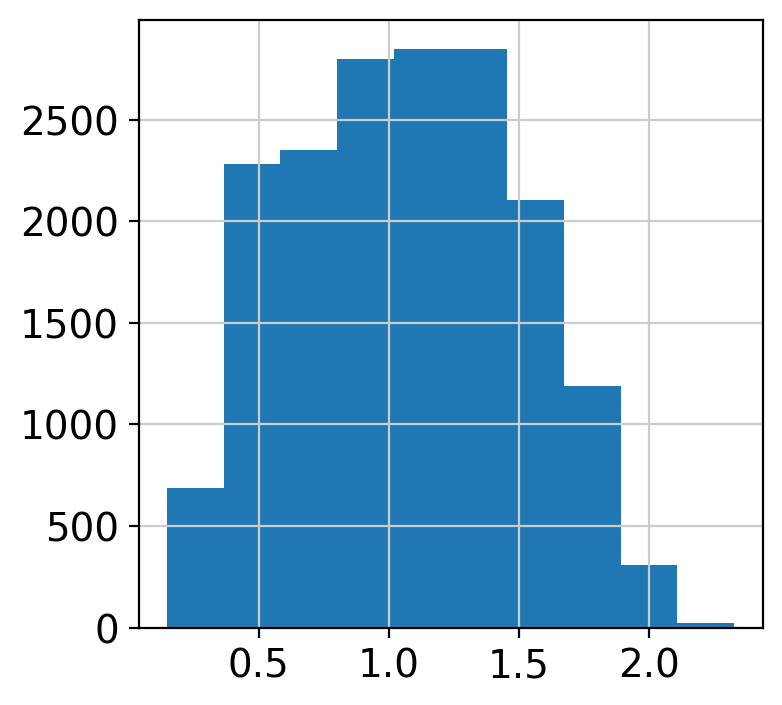

In [41]:
scjp.is_cycling(merged,cc_genes= mouse_cc_genes,cut_off=1.0)

## Merge predicted doublets with scrublet doublets

In [43]:
ndata = merged

In [44]:
scrublet_score_cutoff = 0.7

c1 = ndata.obs['doublet_scores'] > scrublet_score_cutoff
c2 = np.array(ndata.obs['predicted_doublets'])

ndata.obs['scrublet_doublets'] = c1 | c2

# Annotations

In [45]:
ndata

AnnData object with n_obs × n_vars = 17441 × 19601 
    obs: 'Sample', 'n_counts', 'n_genes', 'age', 'doublet_scores', 'predicted_doublets', 'name', 'Cycle_score', 'isCycle', 'scrublet_doublets'

In [46]:
scjp.sc_process(ndata,pid='fpnul')

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00.77)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/ubuntu/.local/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/ubuntu/.local/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../home/ubuntu/.local/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7

    finished (0:00:06.57) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:17.56) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Leiden clustering
    finished (0:00:05.46) --> found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


In [122]:
scjp.write(ndata,version,'tca_mouse')

Only considering the two last: ['.A03', '.tca_mouse'].
HTA08_v01_A03_tca_mouse = 'HTA08.v01.A03.tca_mouse'


## Go to HTA.v01.A02 to finalse TCA annotation

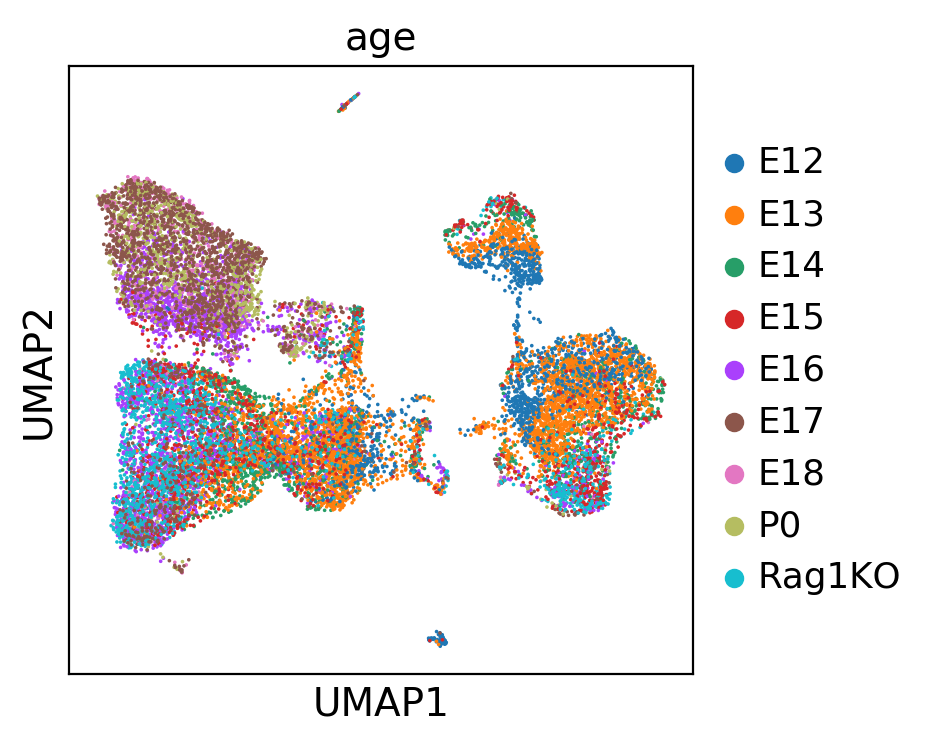

In [48]:
scjp.us(ndata,'age')

## Transfer jp_mouse annotation to TCA dataset

In [73]:
mouse_jp = sc.read('HTA08.v01.A02.mouse_4w8w24w')

Only considering the two last: ['.A02', '.mouse_4w8w24w'].


In [74]:
ndata

AnnData object with n_obs × n_vars = 17441 × 2077 
    obs: 'Sample', 'n_counts', 'n_genes', 'age', 'doublet_scores', 'predicted_doublets', 'name', 'Cycle_score', 'isCycle', 'scrublet_doublets', 'leiden'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'Sample_colors', 'age_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [75]:
mouse_jp

AnnData object with n_obs × n_vars = 19663 × 2927 
    obs: 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'Cycle_score', 'isCycle', 'scrublet_doublets', 'leiden', 'anno_pred', 'anno_level_1', 'anno_level_2', 'anno_level_4', 'anno_level_5'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'anno_level_2_colors', 'anno_level_5_colors', 'anno_pred_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [78]:
jp,tca = scjp.model.get_common_var_raw(mouse_jp,ndata)

calculating a...
calculating b...


creating lr model...
making lr prediction...
updating lr to adata...


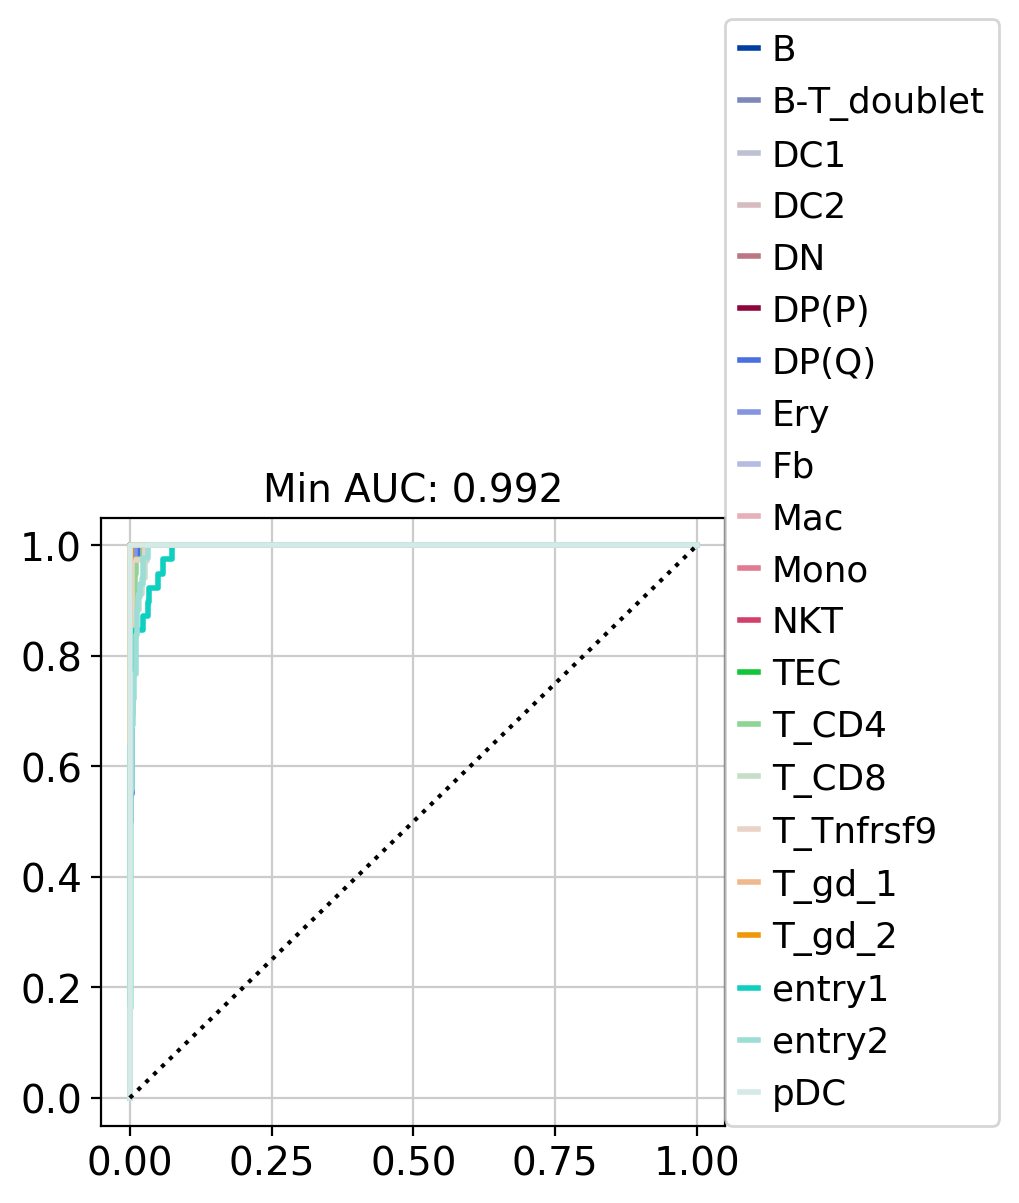

In [83]:
lr_mouse = scjp.model.transfer_annotation_jp(jp,'anno_level_5',tca,'anno_level_5',raw=False,exclude='T_unknown')

... storing 'anno_level_5' as categorical


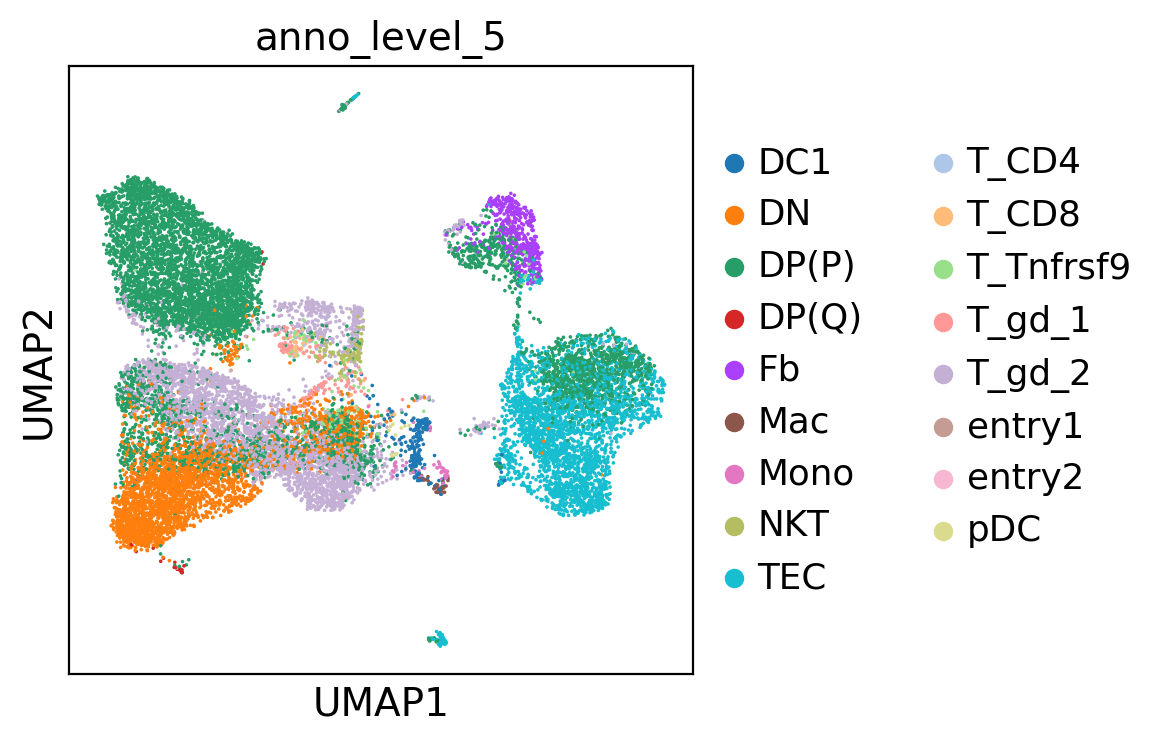

In [84]:
scjp.us(tca,'anno_level_5')

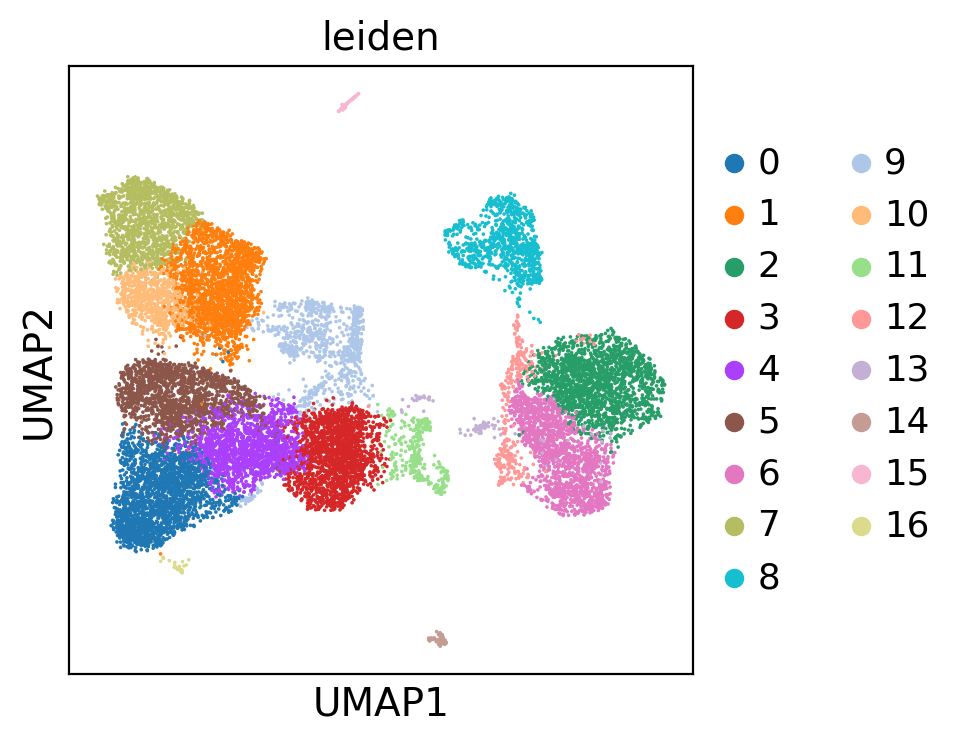

In [87]:
scjp.us(tca,'leiden')

In [124]:
ndata.obs['anno_level_5'] = tca.obs['anno_level_5']

In [125]:
scjp.write(ndata,version,'tca_mouse_annotated')

Only considering the two last: ['.A03', '.tca_mouse_annotated'].
HTA08_v01_A03_tca_mouse_annotated = 'HTA08.v01.A03.tca_mouse_annotated'


In [90]:
tca.raw = tca

In [91]:
mks = scjp.markers.find_markers(tca,'leiden')

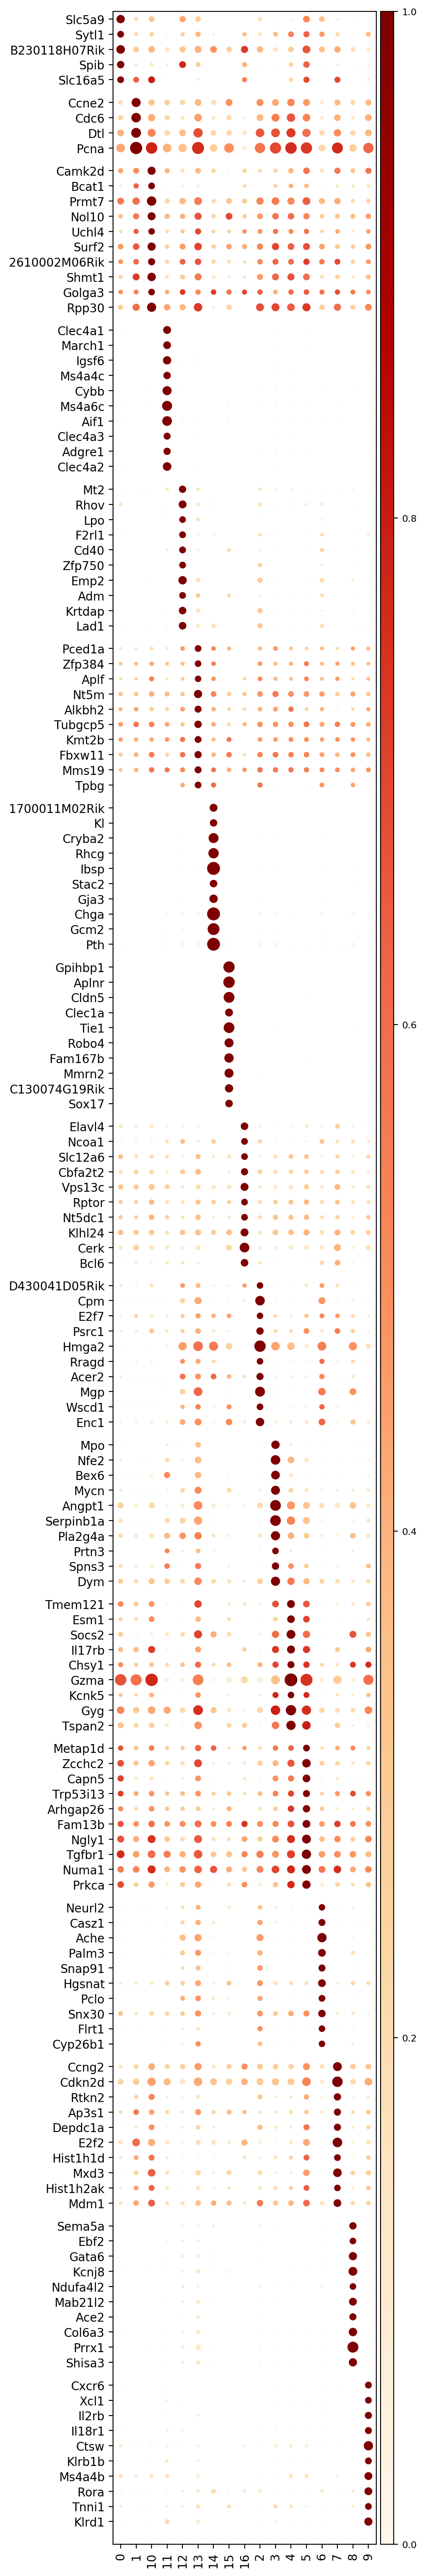

{'0': ['Slc5a9', 'Sytl1', 'B230118H07Rik', 'Spib', 'Slc16a5'],
 '1': ['Ccne2', 'Cdc6', 'Dtl', 'Pcna'],
 '10': ['Camk2d',
  'Bcat1',
  'Prmt7',
  'Nol10',
  'Uchl4',
  'Surf2',
  '2610002M06Rik',
  'Shmt1',
  'Golga3',
  'Rpp30'],
 '11': ['Clec4a1',
  'March1',
  'Igsf6',
  'Ms4a4c',
  'Cybb',
  'Ms4a6c',
  'Aif1',
  'Clec4a3',
  'Adgre1',
  'Clec4a2'],
 '12': ['Mt2',
  'Rhov',
  'Lpo',
  'F2rl1',
  'Cd40',
  'Zfp750',
  'Emp2',
  'Adm',
  'Krtdap',
  'Lad1'],
 '13': ['Pced1a',
  'Zfp384',
  'Aplf',
  'Nt5m',
  'Alkbh2',
  'Tubgcp5',
  'Kmt2b',
  'Fbxw11',
  'Mms19',
  'Tpbg'],
 '14': ['1700011M02Rik',
  'Kl',
  'Cryba2',
  'Rhcg',
  'Ibsp',
  'Stac2',
  'Gja3',
  'Chga',
  'Gcm2',
  'Pth'],
 '15': ['Gpihbp1',
  'Aplnr',
  'Cldn5',
  'Clec1a',
  'Tie1',
  'Robo4',
  'Fam167b',
  'Mmrn2',
  'C130074G19Rik',
  'Sox17'],
 '16': ['Elavl4',
  'Ncoa1',
  'Slc12a6',
  'Cbfa2t2',
  'Vps13c',
  'Rptor',
  'Nt5dc1',
  'Klhl24',
  'Cerk',
  'Bcl6'],
 '2': ['D430041D05Rik',
  'Cpm',
  'E2f7',
  'Ps

In [92]:
scjp.markers.show_marker_plot(tca,'leiden',mks)

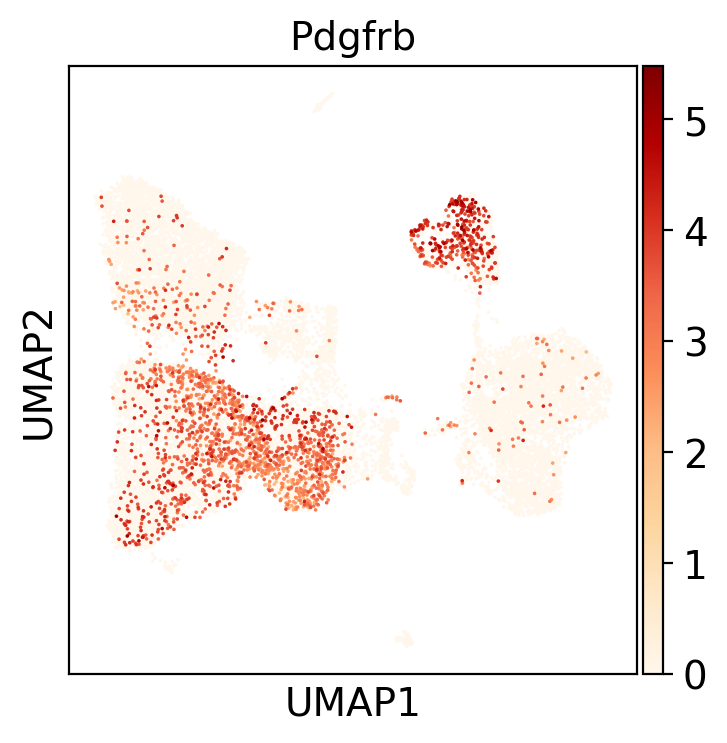

In [119]:
scjp.us(tca,'Pdgfrb')

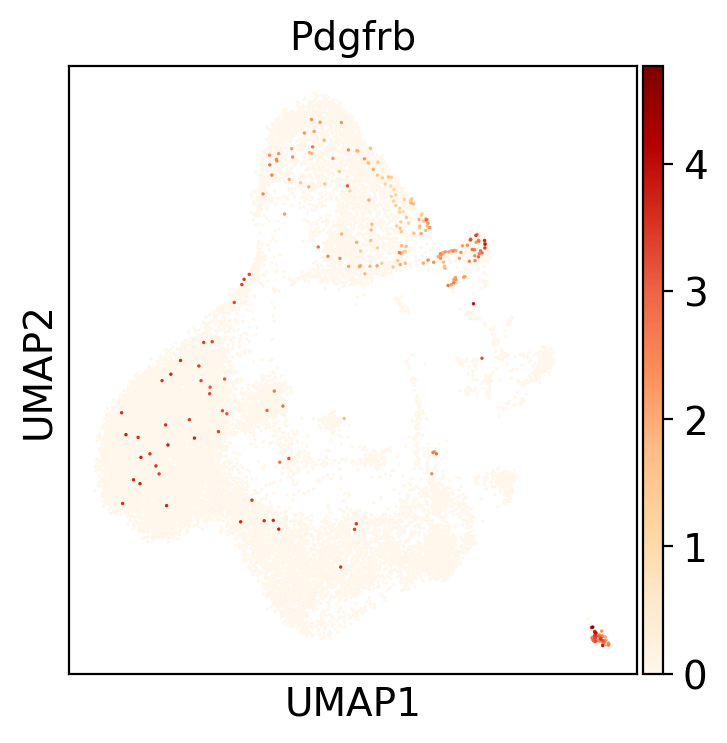

In [121]:
scjp.us(jp,'Pdgfrb')